## Portfolio Assignment week 02

This week's focus is on manifold learning and text clustering. As part of the portfolio assignment, you are required to make a contribution to either the manifold learning case or the text clustering case. There are several options for your contribution, so you can choose the one that aligns with your learning style or interests the most


### Manifold learning

Study the Tutorial tutorial_manifold_tSNE and the tutorial_manifold_spectral_clustering and the Study_Case_pipeline. Next improve the code by comparing the performance of k-means and spectral clustering. Also compare PCA and t-SNE in the visualization of the result. You can use the pipeline function of scikit-learn and hyperparameter tuning with GridSearchCV. Here's a possible approach:

- Load the dataset to be used for the clustering analysis.
- Preprocess the dataset as needed (e.g., scale the features, normalize the data, etc.).
- Define a pipeline with preprocessing and clustering
- use PCA and t-SNE for dimension reduction and visualize the dimensions, use the clusters to color the datapoints
- use GridSearchCV to optimize the hyper parameters
- Evaluate the performance of the models using a suitable metric
- choose the best cluster method and the best visualization method combination

Explain choises and evaluate outcome. You can do this assignment in pairs but if you do so mention each others name. Do not forget to reference. If you cannot figure out how to use GridSearchCV and or a pipeline, use your own solution


### Text clustering

Read, execute and analyse the code in the notebook tutorial_clustering_words. Then *choose one* of the assignments a), b) or c). 

a) read the article Clinical Documents Clustering Based on Medication/Symptom Names Using Multi-View Nonnegative Matrix Factorization. you can find the article <a href = 'https://pubmed.ncbi.nlm.nih.gov/26011887/'> here</a>. Explain the similarities of this notebook and the article. Explain in your own words what need to be added to this notebook to reproduce the article. There is no need to code the solution, you can mention in your own words the steps. 

b) Improve the outcome improving the data preprocessing and the hyper parameter configurations. Explain your choices. Your solution should be a coded solution with comments. Are there any other weighting solutions next to TF-IDF?

c) Provide a text clustering solution with your own data of interest, you can follow a similar approach to the one in the tutorial_clustering_words notebook. 

Mind you that you are not allowed to copy code solutions without referencing.

#### some relevant links:
word clustering: https://towardsdatascience.com/a-friendly-introduction-to-text-clustering-fa996bcefd04

word embedding: https://towardsdatascience.com/introduction-to-word-embeddings-4cf857b12edc

NMF: https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8

Stemming and lemmatization: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

‘pos’ (part of speech) tagging: https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/

TF-IDF: https://towardsdatascience.com/tf-idf-a-visual-explainer-and-python-implementation-on-presidential-inauguration-speeches-2a7671168550



# Assignment 
the assignment that I choose to work on for this assignment is text clustering C.

Provide a text clustering solution with your own data of interest, you can follow a similar approach to the one in the tutorial_clustering_words notebook. 

### Some extra terms :)

When I start to study for this assignment, I thought that text clustering is a boring topic in machine learning. We need to clean a dataset, then implement some techniques to extract a group of topics. However, when I dove deeply into this topic, I found it quite amusing and most importantly informative. Now I am in the situation that I do not know what dataset should I choose since I am quite curious to study about all the Kaggle datasets :). At the end I came up with a fascinating data set about the abstracts of articles in Quantum Physics that gathers all the abstarct of 72880 articles related to different section of this amusing field of science. Consequently, as a datascienctis-physicist, I rather to choose to work on this dataset to find what topics (fields) are hot-topics during 1992-2020 in the field of quantum mechanics.

dataset link: https://www.kaggle.com/datasets/louise2001/quantum-physics-articles-on-arxiv-1994-to-2009/discussion

In [1]:
# import libraries
# General libraries
import re
import os
import string
import glob
import pandas as pd
import numpy as np
import itertools
import yaml

# word clustering libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from pathlib import Path

# Analyzing and Visualizing modules
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import networkx as nx
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

## Data Loading and Inspecting 
In this part first the configue file will be red, then some data inspection will be implemented on the dataset to acquire information about its differnet aspects. Finaly, the required attributes will be extracted and saved in a new data set for further investigation. 

In [2]:
#inspired by https://fennaf.gitbook.io/bfvm22prog1/data-processing/configuration-files/yaml

def configReader():
    """
    explanation: This function open config,yaml file 
    and fetch the gonfigue file information
    input: ...
    output: configue file
    """
    with open("config.yaml", "r") as inputFile:
        config = yaml.safe_load(inputFile)
    return config



In [3]:
def dataframe_maker(config):
    file_directory, file_name = config.values()
    os.chdir(file_directory)
    df = pd.read_csv(file_name)
    return df
df = dataframe_maker(configReader())
df.head()

,title,abstract,categories,created,id,doi
0,"General System theory, Like-Quantum Semantics ...",It is outlined the possibility to extend the q...,"['physics.gen-ph', 'quant-ph']",2007-03-31,0704.0042,NaN
1,Entanglement of Subspaces and Error Correcting...,We introduce the notion of entanglement of sub...,['quant-ph'],2007-04-02,0704.0251,10.1103/PhysRevA.76.042309
2,General sequential quantum cloning,Some multipartite quantum states can be genera...,['quant-ph'],2007-04-03,0704.0323,10.1088/1751-8113/41/15/155303
3,Levy-Lieb constrained-search formulation as a ...,The constrained-search formulation of Levy and...,['quant-ph'],2007-04-03,0704.0372,10.1088/1751-8113/40/11/013
4,Review: Semiconductor Quantum Light Sources,Lasers and LEDs display a statistical distribu...,['quant-ph'],2007-04-03,0704.0403,10.1038/nphoton.2007.46


This dataset contains six topics (title, absttact, categories, created, id, doi). also it contains 72880 articles (samples). in the next part some data inspection will perfome on the dataset to gain more information about the dataset.

In [4]:
# make a data inspection function
def data_inspector(df):
    # find the number of null values in the dataset.
    null_values = df.isnull().sum()
    print(f'the number of null value in each column is:\n{null_values}\n')

    # find the number of categories in the dataset
    categories_list = df.categories.unique()
    print(f'number of different categories: {len(categories_list)}')
    print('however most of these topics are a mixture of basic topics\n')

    # find the time period for this publishing these articles
    date_list = pd.to_datetime(df.created)
    print(f'this dataset ranges from {date_list.dt.year.min()} to {date_list.dt.year.max()}\n')

    # find whether an id is assigned to more than one article
    unique_ids = df.id.unique()
    print(f'total number of ids is {len(df.id)}\nthe number of unique ids is {len(unique_ids)}')

data_inspector(df)

the number of null value in each column is:
title             0
abstract          0
categories        0
created           0
id                0
doi           21051
dtype: int64

number of different categories: 4174
however most of these topics are a mixture of basic topics

this dataset ranges from 1992 to 2020

total number of ids is 72881
the number of unique ids is 72881


Based on the data inspection part, one can infer that the best attribute for assigning as index is id since first doi contains many null values, also there are unique id for each article.

One can decide to work on the abstracts or on the titles. I personally think abstracts are more informative since they contain more information. Consequently in the next step I will make a series that contains all the abstracts as the values and ids as their index.

In [5]:
abstract_df = df[['id', 'abstract']]
abstract_df = abstract_df.set_index('id')
abstract_df.head()

,abstract
id,
0704.0042,It is outlined the possibility to extend the q...
0704.0251,We introduce the notion of entanglement of sub...
0704.0323,Some multipartite quantum states can be genera...
0704.0372,The constrained-search formulation of Levy and...
0704.0403,Lasers and LEDs display a statistical distribu...


## Cleaning Texts
In this section, I will utilize the function featured and designed in the link provided below. Moreover, I will focus solely on the nouns as the research question aims to identify the hot topics in Quantum Mechanics over the past three decades. Therefore, the essential terms will consist of nouns encompassing subjects, techniques, particle names, and similar concepts.

https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8

Also, one can find more information about the following functions and also the modules that are used inside them in the tutorial_clustering_words.ipynb file in this folder or on the following link.



In [6]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    and remove words containing numbers.'''
    text = text.lower()
    # replace anything that exists in a square bracket with space
    text = re.sub('\[.*?\]', ' ', text)
    # %s means its a string, %d is an integer, %f is floating point number.
    # escape is a function that escapes any special characters present in the the string.
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # '\w*\d\w*' is a regular expression pattern that matches any word that contains at least one digit.
    text = re.sub('\w*\d\w*', ' ', text)
    # replace the errors with space
    text = re.sub('�', ' ', text)
    return text

cleaned = lambda x: clean_text(x)

In [7]:
# Noun extract and lemmatize function
def nouns(text):
    '''Given a string of text, tokenize the text 
    and pull out only the nouns.'''
    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == 'NN'
    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()
    # use list comprehension to lemmatize all words 
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    
    #return string of joined list of nouns
    return ' '.join(all_nouns)

In [8]:
# Clean Text
abstract_df["abstract"] = abstract_df["abstract"].apply(cleaned)
data_nouns = pd.DataFrame(abstract_df["abstract"].apply(nouns))
# Visually Inspect
data_nouns.head()

,abstract
id,
0704.0042,possibility quantum formalism relation require...
0704.0251,notion entanglement subspace measure entanglem...
0704.0323,state manner setup microwave cavity qed ion do...
0704.0372,search formulation levy lieb hohenberg electro...
0704.0403,laser led distribution number photon time appl...


At this stage the data has cleaned and all the nouns has been extracted from the abstract. Consequently, the corpus is ready for further investigation. In the next step the Document-Term matrix (DTM) will be extracted using TF-IDF (Term Frequency-Inverse Document Frequency) method. For further information about TF-IDF and also TfidfVectorizer Sklearn class one can study tutorial_clustering_words.ipynb.

## The Document-Term Matrix (DTM)
In this stage one needs to extract DTM to use it as the input of NMF method. Again I will use the funtions introduced in the tutorial notebook. Also I added some documentation and explanations to it.

In [9]:
def dtm_maker(data_nouns):
    # Create a document-term matrix with only nouns
    # Store TF-IDF Vectorizer
    tv_noun = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS, ngram_range = (1,1), max_df = .8, min_df = .01)
    # Fit and Transform speech noun text to a TF-IDF Doc-Term Matrix
    data_tv_noun = tv_noun.fit_transform(data_nouns.abstract)
    # Create data-frame of Doc-Term Matrix with nouns as column names
    # first it changes the data_tv_noun to an array and then use the nouns exist in tv_noun as the columns of the dataset
    data_dtm_noun = pd.DataFrame(data_tv_noun.toarray(), columns=tv_noun.get_feature_names_out())
    data_dtm_noun.index = df.index
    # Visually inspect Document Term Matrix
    return tv_noun, data_dtm_noun

tv_noun, data_dtm_noun = dtm_maker(data_nouns)
data_dtm_noun.head()

,ability,absence,absorption,access,account,accuracy,action,addition,advantage,agreement,...,waveguide,wavelength,way,width,wigner,work,world,year,yield,zero
0,0.0,0.0,0.0,0.0,0.269073,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.19872,0.0,0.0


By utilizing TfidfVectorizer module, 539 most important terms of this corpus come to existance. In the next step one can implement NMF Sklearn module to make document-topic and topic-term matrices. Again for more information about the functions one can study the tutorial part.

## NMF
I made a small function to make an NMF object, then use it in the display_topic() function.

In [10]:
def nmf_maker(df, topic_number):
    nmf_model = NMF(topic_number)
    doc_topic = nmf_model.fit_transform(df)
    return nmf_model, doc_topic

def display_topics(model, feature_names, num_top_words, topic_names=None):
    '''Given an NMF model, feature_names, and number of top words, print 
       topic number and its top feature names, up to specified number of top words.'''
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, topic in enumerate(model.components_):
        #print topic, topic number, and top words
        # if there is no topic or term print
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        # print topics and their most frequent words
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [15]:
# make the NMF model and its relavent matrices
nmf_model, doc_topic = nmf_maker(data_dtm_noun, 5)
topic_terms = nmf_model.components_
noun_names = tv_noun.get_feature_names_out()
display_topics(nmf_model, noun_names, 10)

c:\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(



Topic  0
quantum, protocol, measurement, information, channel, qubit, algorithm, error, gate, qubits

Topic  1
time, equation, theory, particle, function, model, energy, space, quantum, field

Topic  2
photon, cavity, mode, atom, field, frequency, source, light, laser, emission

Topic  3
state, entanglement, measurement, correlation, measure, entropy, inequality, qubit, ground, bound

Topic  4
spin, phase, field, interaction, transition, model, electron, chain, atom, temperature


I explored a range of topics, varying from 5 to 20, within the corpus. Through this experimentation, I discovered that extracting five topics successfully captured the five primary subcategories of Quantum Physics. As the number of topics increased, these major subjects further fragmented into their respective sub-parts. This fragmentation remains valid, considering that each major subtopic comprises numerous distinct components. However, for the purpose of this limited study, isolating the primary subject of quantum mechanics should suffice. Furthermore, Opting for fewer than five topics would not adequately encompass all the major subjects within Quantum Mechanics. Subsequently, I will proceed with these five major topics, and employ various analysis and visualization techniques to further investigate them.

#### Topic Names
Based on my knowledge, it is possible for me to assign names to these topics. However, it is important to acknowledge that these names are subjective and subject to individual interpretation. Thus, another person may assign similar yet distinct names to the topics.

names:

A) topic1: Quantum Computing

B) topic2: Quantum Field Theory

C) topic3: Quantum Optics

D) topic4: Foundations of Quantum Mechanics

E) topic5: Solid State Physics

Now, I will use some analyzing and visualizing methods to extract more information from these topics.


In [28]:
topic_names = ['Quantum Computing', 'Quantum Field Theory', 'Quantum Optics', 'Foundations of Quantum Mechanics', 'Solid State Physics']


## Visualization and Analytical Methods:

### Word Clouds:
A tag cloud (also known as a word cloud, wordle or weighted list in visual design) is a visual representation of text data which is often used to depict keyword metadata on websites, or to visualize free form text. Tags are usually single words, and the importance of each tag is shown with font size or color. When used as website navigation aids, the terms are hyperlinked to items associated with the tag. [Wiki]

https://en.wikipedia.org/wiki/Tag_cloud

In this study, I will use wordcloud library

https://pypi.org/project/wordcloud/


In [29]:
def dictionary_maker(keys, values, order=1, slice_number=False):

    # making the dictionary of words with their magnitude in each topic
    dictionary = {}
    for counter, key in enumerate(keys):
        dictionary[key] = values[counter]

    # sort the dictionary in an ascending or descending order
    dictionary = dict(sorted(dictionary.items(), key=lambda item: order * item[1]))

    # slice the dictionary if needed
    if slice_number != False:
        dictionary = dict(itertools.islice(dictionary.items(), slice_number))
    
    return dictionary

In [30]:
def worldcloud_plot_maker(df, word_list, title_list=[], order=-1, row_column=0, color_map='magma'):
    # sketch the main plot
    fig = plt.figure(figsize=(10, 18.6))
    plot_number = df.shape[row_column]

    for number in range(plot_number):
        # sketch the sub-plot
        fig.add_subplot(plot_number,1,number+1)

        if len(title_list) == 0:
            plt.title(f'topic{number+1}', fontsize=15)        
        else:
            plt.title(title_list[number],fontsize=15)

        if row_column == 0:
            dictionary = dictionary_maker(word_list, df[number, :], order=order)
        else:
            dictionary = dictionary_maker(word_list, df[:, number], order=order)

        wordcloud = WordCloud(background_color='white',  colormap=color_map)
        wordcloud.generate_from_frequencies(dictionary) 
        
        plt.imshow(wordcloud, interpolation="bilinear")

        plt.axis("off")
    
        plt.show()

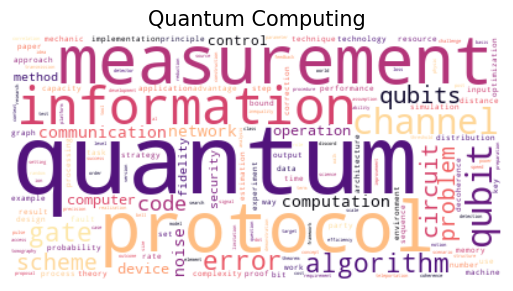

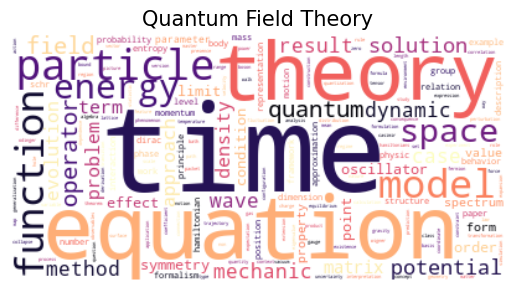

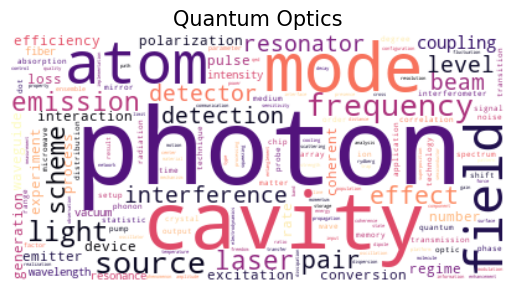

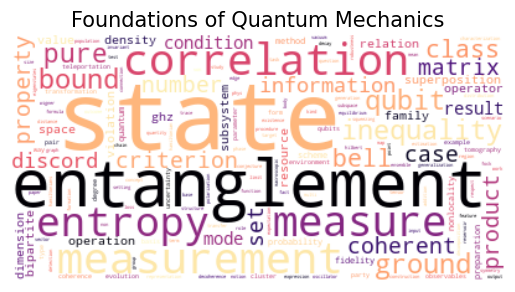

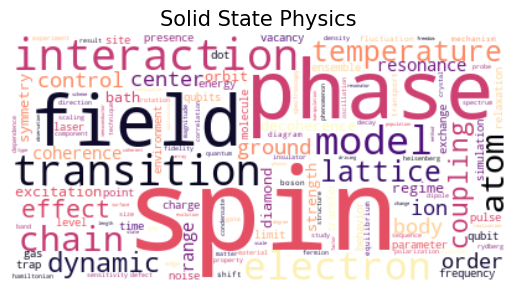

In [31]:
worldcloud_plot_maker(df=topic_terms, word_list=noun_names, title_list=topic_names)

Word clouds offer a visually friendly approach to identifying differences between topics. By representing words with varying sizes, where larger words indicate greater importance, one can easily detect key terms within a topic. This analytical tool proves invaluable in assessing topic separation. Additionally, I found that the subjective names I assigned to the topics in the previous section were validated by the word cloud analysis. The presence of more related words within each topic further supports the accuracy of my naming choices.

Notice that one can use the above word cloud functions to evaluate the relationship between documents-terms or documents-topics. Another way of analyzing the relation between topics and terms is Heatmaps, However since the number of terms is about five hundreds and we have only 5 topics the word cloud can be a better representator of the mentioned relation. Also, heatmaps can be used for documents-terms or documents-topics. However, since the number of documents and terms are quite large, one can used word clouds or other visualizing techniques. The Heatmap technique is used in the tutorial_clustering_words.ipynb for the "MACCROBAT2020" dataset, so one can have a look at the mentioned file to find the functions and visualization type.

In the next step one can find the contribution of each topic in the courpus by using a barchart.

### Topic Distribution Bar Chart:
Create a bar chart showing the distribution of topics across the entire corpus. This visualization can give one an understanding of the prevalence and proportions of different topics within a dataset. In this specific study one can find the proportion of articles published with these topics in these three decades.

In [32]:
def bar_chart_maker(df, axis, topic_list=[], xlabel='topics'):
    normalized_topic_weights = df.sum(axis= axis) / df.sum()

    x_axis = np.arange(len(normalized_topic_weights))

    fig, ax = plt.subplots()

    ax.bar(x_axis, normalized_topic_weights)

    # changing the range numbers into these topics
    if len(topic_list) == 0:
        topic_list = []

        for number in range(len(normalized_topic_weights)):
            topic_list.append(f'{xlabel} {number+1}')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.xticks(x_axis, topic_list)
    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel('Proportion')
    plt.title(f'{xlabel} Distribution')

    # Display the chart
    plt.show()

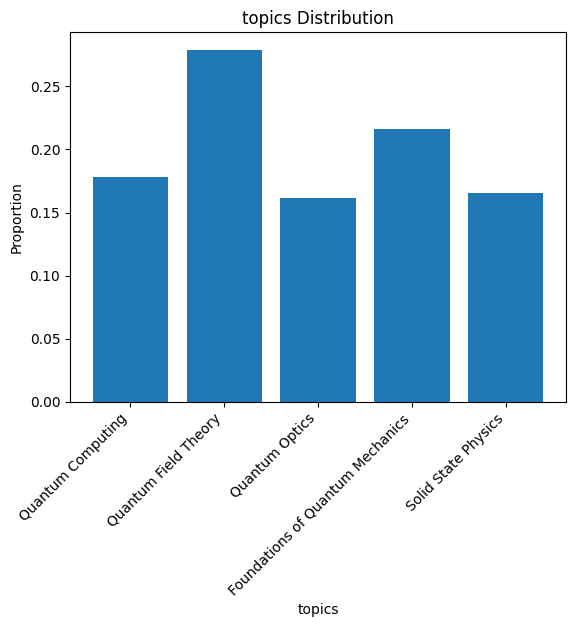

In [33]:
bar_chart_maker(doc_topic, axis=0, topic_list=topic_names)

I find the results quite fascinating as they reveal the prominence of various topics within the field of quantum mechanics based on the number of publications. Over the past thirty years, Quantum Field Theory emerged as the hottest topic, accounting for more than 27% of all articles in Quantum Mechanics. Following closely behind is the Foundation and theoretical aspects of Quantum Mechanics, which collect over 23% of the publications. Additionally, the application of Quantum Mechanics principles in other fields, such as computing, optics, and Solid State Physics, collectively secured the third position, each contributing roughly 17%. These findings shed light on the distribution of research focus within the realm of quantum mechanics.

To continue this study, one can find the shared terms between topics by using Topic Network.

### Topic Network
Construct a network visualization where topics are represented as nodes and their connections are based on shared terms or similarity measures. This can help identify relationships and overlaps between topics.

In [35]:
def dict_maker(model, feature_names, topic_list, num_top_words, threshold=0.1, opic_names=None):
    dictionary = {}
    for ix, topic in enumerate(model):
    
        if len(topic_list) == 0:
            dictionary[f'topic{ix+1}'] = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1] if topic[i] > threshold] 

        else:
            dictionary[topic_list[ix]] = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1] if topic[i] > threshold]    
    return dictionary

Here I implement some constrains to make this function:1- I suppose that the topic-term matrix does not need normalization as the scale is the same for all the topics and the variace does not have a wide range. 2- I suppose two threshold limits on the number of highly expressed terms first I limit their numbers to ten first expressed terms and second I impose a treshold on the magnitude of the value of each word for a topic and put a diffault of 0.1, but based on the lenght of the passages and the type of data sets these constraints can be varied.

In [36]:
def topic_network(model, feature_names, topic_list, num_top_words, threshold=0.1, opic_names=None):
    topic_terms_dict = dict_maker(model, feature_names, topic_list, num_top_words, threshold=0.1, opic_names=None)
    topics = list(topic_terms_dict.keys())
    # Create an empty graph
    G = nx.Graph()

    # Add nodes for each topic
    G.add_nodes_from(topics)

    # Connect topics based on shared terms
    for i in range(len(topics)):
        for j in range(i + 1, len(topics)):
            shared_terms = set(topic_terms_dict[topics[i]]) & set(topic_terms_dict[topics[j]])
            if len(shared_terms) > 0:
                G.add_edge(topics[i], topics[j], shared_terms=list(shared_terms))

    # Visualize the topic network
    pos = nx.spring_layout(G)  # Choose a layout algorithm (e.g., spring_layout)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)

    # Customize the visualization
    edge_labels = nx.get_edge_attributes(G, "shared_terms")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Topic Network")
    plt.axis("off")
    plt.show()

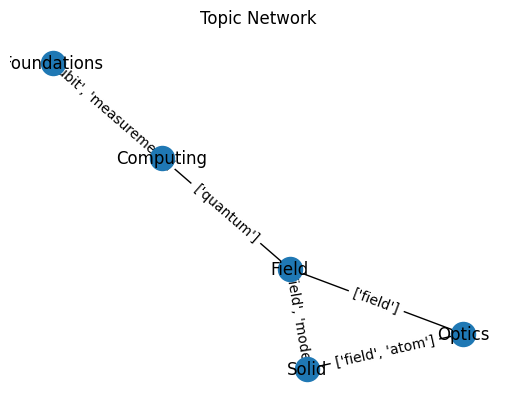

In [44]:
summary_name_list = ['Computing', 'Field', 'Optics', 'Foundations', 'Solid']
topic_network(topic_terms, noun_names, summary_name_list, 10, threshold=0.1)

Based on the above Topic Network one can find that Between three topics 'Quantum Field Theory', 'Quantum Optics' and 'Solid States Physics' term Field is in common. I believe that the main reason for this coincidence is that the term field in optics and solid states Physics refers to  elecrical and magnetic fields while in Quantum Field theory it refers to Quantum potential fields. Consequently, the word field refers to different physical concepts, but yet these concepts are quite applicable in these fields. Again this analysis can be correct for the term 'mode' between  'Quantum Field Theory' AND 'Solid States Physics' as this mode refers to diferent concepts in these two fields. However, the term 'atom' in 'Quantum Optics' and 'Solid States Physics' present the same bu quite applicable concept in both of these subjects. Furthermore, between the 'foundations of Quantum Mecanics' and 'Quantum Comupting' two terms are in common first one is measurment and the second one is Quibit that may shows that one of the most studied topics in foundation and theoretical Quantum physics in the last thirty years was establishing the theoretical aspects of Quantum Computing that make sense when one thinks about the history of the emergence of quantum computers. Finally, Regarding 'Quantum Field Theory' and 'Quantum Computing' the term 'quantum' is in common, that can be deducable.